### Hackathon 1: Optimisation of a non-convex 2-D function with Bayesian Optimisation

#### Package Imports

In [3]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.integrate import quad
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
import math
import time
import sobol_seq

#### Attempt

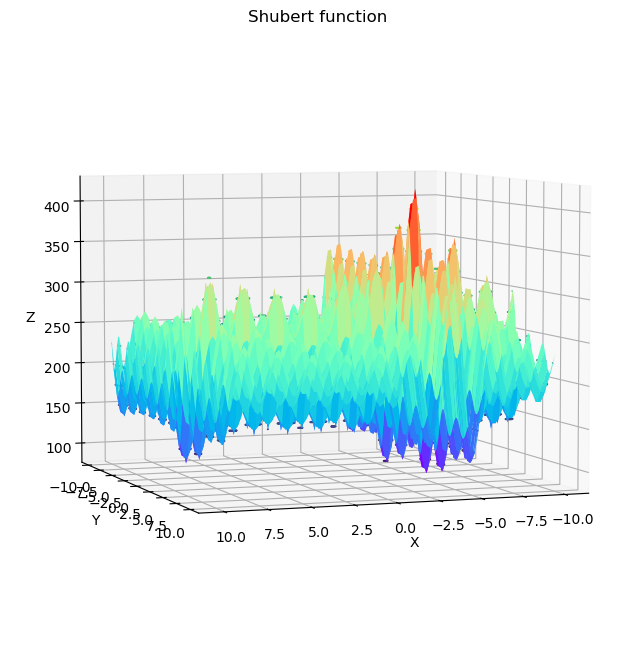

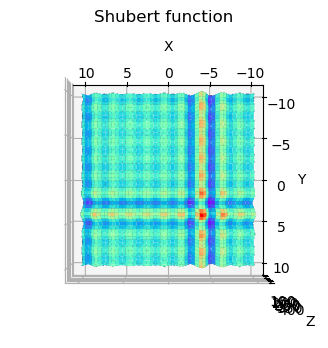

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import sin
from numpy import *
from numpy import pi
from numpy import sqrt
from matplotlib import cm

def f(x1,x2):
      sum1=0
      sum2=0
      for c in range(1,6):
          i = c *0.4
          sum1 = sum1 + (i* cos(((i+1)*(x1+3.24)) +i)) + 2 * i
          sum2 = sum2 + (i* cos(((i+1)*(x2-4.57)) +i)) + 3 * i
      return sum1 * sum2
 
x1 =np.linspace(-10,10,100)
x2 =np.linspace(-10,10,100)
r_min,r_max= -10,10

x1,x2=np.meshgrid(x1,x2)
results=f(x1,x2)

axis=plt.figure(figsize=(8,8)).add_subplot(projection='3d')
#axis.contour3D(x1, x2, results,15)
axis.set_title('Shubert function')
axis.plot_surface(x1,x2,results, cmap=cm.rainbow)


axis.view_init(elev=5,azim=70)
axis.set_xlabel('X')
axis.set_ylabel('Y')
axis.set_zlabel('Z')
plt.contour(x1, x2, results,15)
plt.show()

axis=plt.figure(figsize=(4,4)).add_subplot(projection='3d')
#axis.contour3D(x1, x2, results,15)
axis.set_title('Shubert function')
axis.plot_surface(x1,x2,results, cmap=cm.rainbow)


axis.view_init(elev=90,azim=90)
axis.set_xlabel('X')
axis.set_ylabel('Y')
axis.set_zlabel('Z')
plt.contour(x1, x2, results,15)
plt.show()

In [10]:
class GP:
    def __init__(self, X, Y, kernel):
        
        self.X, self.Y, self.kernel                                  = X, Y, kernel
        self.number_of_point, self.nx_dimensions, self.ny_dimensions = X.shape[0], X.shape[1], Y.shape[1]
        self.multistart_loops                                        = 3

        self.X_mean, self.X_std     = np.mean(X, axis=0), np.std(X, axis=0)
        self.Y_mean, self.Y_std     = np.mean(Y, axis=0), np.std(Y, axis=0)
        self.X_norm, self.Y_norm    = (X-self.X_mean)/self.X_std, (Y-self.Y_mean)/self.Y_std

        self.hyperparam_optimized , self.inverse_covariance_matrix_opt   = self.determine_hyperparameters()     
        
    def Cov_mat(self, kernel, X_norm, W, sf2):
        if kernel == 'SquaredExponential':
            xixj_euclidean_distance = cdist(X_norm, X_norm, 'seuclidean', V=W)**2 
            cov_matrix = sf2*np.exp(-0.5*xixj_euclidean_distance)
            return (cov_matrix)
        else:
            print('ERROR no kernel with name ', kernel)

    def negative_loglikelihood(self, hyper, X, Y):
        n_point, nx_dim = self.number_of_point, self.nx_dimensions
        kernel          = self.kernel
        
        W               = np.exp(2*hyper[:nx_dim])   
        sf2             = np.exp(2*hyper[nx_dim])    
        sn2             = np.exp(2*hyper[nx_dim+1])  

        K       = self.Cov_mat(kernel, X, W, sf2)  
        K       = K + (sn2 + 1e-8)*np.eye(n_point)
        K       = (K + K.T)*0.5                    
        L       = np.linalg.cholesky(K)           
        logdetK = 2 * np.sum(np.log(np.diag(L)))   
        invLY   = np.linalg.solve(L,Y)             
        alpha   = np.linalg.solve(L.T,invLY)       
        NLL     = np.dot(Y.T,alpha) + logdetK      
        return (NLL)

    def determine_hyperparameters(self): 
        lower_bound = np.array([-4.]*(self.nx_dimensions+1) + [-8.])  
        upper_bound = np.array([4.]*(self.nx_dimensions+1) + [ -2.]) 
        bounds      = np.hstack((lower_bound.reshape(self.nx_dimensions+2,1), upper_bound.reshape(self.nx_dimensions+2,1)))
    
        multi_startvec                = sobol_seq.i4_sobol_generate(self.nx_dimensions + 2, self.multistart_loops)
        
        temp_min_hyperparams          = [0.]*self.multistart_loops
        temp_loglikelihood            = np.zeros((self.multistart_loops))
        hyperparam_optimized          = np.zeros((self.nx_dimensions+2, self.ny_dimensions)) #for best solutions
        inverse_covariance_matrix_opt = []
        
        for i in range(self.ny_dimensions):
            for j in range(self.multistart_loops ):
                hyperparams_initialisation   = lower_bound + (upper_bound-lower_bound)*multi_startvec[j,:] # mapping sobol unit cube to boudns
                result  = minimize(self.negative_loglikelihood,
                                   hyperparams_initialisation,
                                   args     = (self.X_norm, self.Y_norm[:,i]),
                                   method   = 'SLSQP',
                                   options  = {'disp':False,'maxiter':10000},
                                   bounds   = bounds,
                                   tol      = 1e-12)
                temp_min_hyperparams[j] = result.x
                temp_loglikelihood[j]   = result.fun  

            minimumloglikelihood_index    = np.argmin(temp_loglikelihood)
            hyperparam_optimized[:,i]     = temp_min_hyperparams[minimumloglikelihood_index  ]
    
            lengthscale_opt         = np.exp(2.*hyperparam_optimized[:self.nx_dimensions,i])
            signalvarience_opt      = np.exp(2.*hyperparam_optimized[self.nx_dimensions,i])
            noise_opt               = np.exp(2.*hyperparam_optimized[self.nx_dimensions+1,i]) + 1e-8
    
            covarience_matrix_opt              = self.Cov_mat(self.kernel, self.X_norm, lengthscale_opt,signalvarience_opt) + noise_opt*np.eye(self.number_of_point)   
            inverse_covariance_matrix_opt     += [np.linalg.solve(covarience_matrix_opt, np.eye(self.number_of_point))]
        return (hyperparam_optimized , inverse_covariance_matrix_opt)


    def calc_cov_sample(self,xnorm,Xnorm,ell,sf2):
        nx_dim     = self.nx_dimensions
        dist       = cdist(Xnorm, xnorm.reshape(1,nx_dim), 'seuclidean', V=ell)**2
        cov_matrix = sf2 * np.exp(-.5*dist)
        return (cov_matrix )         


    def GP_inference_np(self, x):
        nx_dim                   = self.nx_dimensions
        kernel, ny_dim           = self.kernel, self.ny_dimensions
        hypopt, Cov_mat          = self.hyperparam_optimized, self.Cov_mat
        stdX, stdY, meanX, meanY = self.X_std, self.Y_std, self.X_mean, self.Y_mean
        calc_cov_sample          = self.calc_cov_sample
        invKsample               = self.inverse_covariance_matrix_opt
        Xsample, Ysample         = self.X_norm, self.Y_norm

        xnorm = (x - meanX)/stdX
        mean  = np.zeros(ny_dim)
        var   = np.zeros(ny_dim)
        
        for i in range(ny_dim):
            invK           = invKsample[i]
            hyper          = hypopt[:,i]
            ellopt, sf2opt = np.exp(2*hyper[:nx_dim]), np.exp(2*hyper[nx_dim])

            k             = calc_cov_sample(xnorm,Xsample,ellopt,sf2opt)
            raw_mean      = np.matmul(np.matmul(k.T,invK),Ysample[:,i]).item()
            mean[i]       = raw_mean
            raw_var_array = np.maximum(0, sf2opt - (k.T @ invK @ k)).item()
            raw_var       = raw_var_array
            var[i]        = raw_var
    
        mean_sample = mean*stdY + meanY
        var_sample  = var*stdY**2
        
        return (mean_sample, var_sample)


In [11]:
class BO: 
    def __init__(self, X, kernel, aquisition_function, objective_func, aquisition_hyperparam, iterations):       
        number_points_pervariable      = 100
        number_points_searchspace      = number_points_pervariable ** (np.shape(X_training)[1])
        X_searchspace                  = np.linspace(-10, 10, num=number_points_pervariable)
        X_searchspace                  = np.array([[x,y] for x in X_searchspace for y in X_searchspace])
        
        self.X, self.iterations  = X, iterations
        Fx_training              = np.array([objective_func(x) for x in X_training])
        self.Y                   = Fx_training.reshape(Fx_training.shape[0],1)
        
        fx_searchspace           = np.array([objective_func(x) for x in X_searchspace])
        n_candidates             = X_searchspace.shape[0]
        Ysearchspace_mean        = np.zeros(n_candidates)
        Ysearchspace_std         = np.zeros(n_candidates)

        
        self.minY      = []
        self.exploredY = []
        
        for i in range(iterations):
            GP_m = GP(self.X, self.Y, kernel)
            
            for number in range(len(X_searchspace)):
                m_ii, std_ii   = GP_m.GP_inference_np(X_searchspace[number])
                Ysearchspace_mean[number] = m_ii.item()
                Ysearchspace_std[number]  = std_ii.item()
   
            if aquisition_function == 'LCB':
                X_aquisitionfunc = self.lower_confidence_bound(X_searchspace,Ysearchspace_mean, Ysearchspace_std,aquisition_hyperparam )
            else: 
                print('No aquisition function called ', aquisition_function)
                break
            
            self.X = np.append(self.X, [X_aquisitionfunc],0)
            self.Y = np.append(self.Y, [[objective_func(X_aquisitionfunc)]],0)

            self.minY += [min(self.Y)]
            self.exploredY += [objective_func(X_aquisitionfunc)]

        print(self.minimum_discovered())
    
    def lower_confidence_bound(self, X_searchspace, Ysearchspace_mean, Ysearchspace_std, aquisition_hyperparam = [3]):
        lower_std = Ysearchspace_mean - aquisition_hyperparam[0]*np.sqrt(Ysearchspace_std)
        return (X_searchspace[np.argmin(lower_std)])

    def minimum_discovered(self):
        return(min(self.Y))
    def advanced_penalty(self):
        return(min(self.Y)+ self.iterations)


In [14]:
def obj_func(X):
      sum1=0
      sum2=0
      for c in range(1,6):
          i = c *0.4
          sum1 = sum1 + (i* np.cos(((i+1)*(X[0]+3.24)) +i)) + 2 * i
          sum2 = sum2 + (i* np.cos(((i+1)*(X[1]-4.57)) +i)) + 3 * i
      return sum1 * sum2


# --- define training data 
x1loc  = [1,2,3,4,5]; x2loc = [1,2,3,4,5]
X_training = np.array([[x,y] for x in x1loc for y in x2loc])

BO(X = X_training,  
   kernel = 'SquaredExponential', 
   iterations = 50, 
   aquisition_function = 'LCB', 
   objective_func = obj_func, 
   aquisition_hyperparam=[3])

144.43932024025273
